# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# Note: because of a version problem with matplot lib, the following line of code doesn't work in this workspace.
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

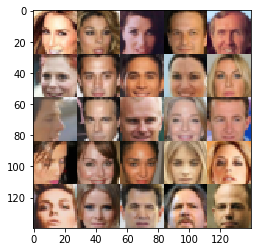

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    lr = tf.placeholder(tf.float32)
    return real_input,input_z,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha * x1,x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        relu2= tf.maximum(alpha* x2,x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha *x3,x3)
        #  4x4x256
        
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        
    return out , logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator',reuse=not is_train):
        x = tf.layers.dense(z,2*2*512)
        x1 = tf.reshape(x,(-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='valid')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2,x2)
        # 4x4x256
        
        x3 = tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x64
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same')
        # 32x32x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z,out_channel_dim)
    d_model_real ,d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
c = np.random.uniform(-1,1,(50))
print (c.shape)
print (c)

(50,)
[-0.28308002 -0.83185373 -0.63207576  0.71833931  0.92120381  0.83917218
  0.87849602 -0.49393436 -0.40447173 -0.62121921 -0.33966698 -0.41224232
 -0.66488567  0.62038441  0.73242554  0.1340387  -0.54575444 -0.8580521
  0.88738267 -0.03828625  0.09557648  0.2543025   0.49156346 -0.05942644
  0.30290083 -0.11882622 -0.53830639 -0.60504524  0.9531035   0.96456238
  0.55535806  0.74444884 -0.80385772 -0.18159668  0.51590213  0.05703462
 -0.13829599  0.32371621  0.38048189  0.21337293  0.36767262 -0.67068866
  0.97961885 -0.52411951 -0.38642044  0.01316223  0.32036743 -0.54499532
 -0.58818112  0.30728244]


In [12]:


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
   
    
    # Determine number of image channels
    out_channels = 0
    if data_image_mode == 'RGB':
        out_channels = 3
    else:
        out_channels = 1
    
    images_tensor, z_tensor, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) 
    d_loss, g_loss = model_loss(images_tensor, z_tensor, out_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))  # Generate noise to check sample outputs during training

    # Track steps for determining when to show loss & sample outputs
    steps = 0
    
    # Train the Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1  # Increment steps for each batch
                batch_images *= 2.0

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images_tensor: batch_images, z_tensor: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_tensor: batch_z, images_tensor: batch_images, lr_tensor: learning_rate})

                if steps % 10 == 0:
                    # At the end of a given number of steps, get the losses and print them out
                    train_loss_d = d_loss.eval({z_tensor: batch_z, images_tensor: batch_images})
                    train_loss_g = g_loss.eval({z_tensor: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:  # Show samples every 100 steps
                    _ = show_generator_output(sess, 72, z_tensor, out_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1086... Generator Loss: 13.2884
Epoch 1/2... Discriminator Loss: 2.6873... Generator Loss: 9.6668
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 2.6678
Epoch 1/2... Discriminator Loss: 0.7071... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 2.4324... Generator Loss: 0.3026
Epoch 1/2... Discriminator Loss: 0.2268... Generator Loss: 2.1260
Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 4.9043
Epoch 1/2... Discriminator Loss: 0.7350... Generator Loss: 1.0148
Epoch 1/2... Discriminator Loss: 0.1401... Generator Loss: 2.2675
Epoch 1/2... Discriminator Loss: 0.3064... Generator Loss: 2.3341


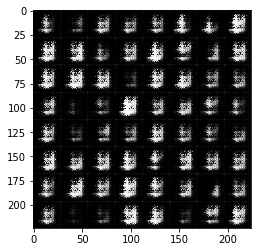

Epoch 1/2... Discriminator Loss: 0.1836... Generator Loss: 2.1003
Epoch 1/2... Discriminator Loss: 0.2158... Generator Loss: 2.2700
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 2.8591
Epoch 1/2... Discriminator Loss: 0.2654... Generator Loss: 2.2874
Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 0.3112... Generator Loss: 1.9683
Epoch 1/2... Discriminator Loss: 0.1056... Generator Loss: 4.2230
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 1.5607
Epoch 1/2... Discriminator Loss: 0.0521... Generator Loss: 5.6133
Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 2.4495


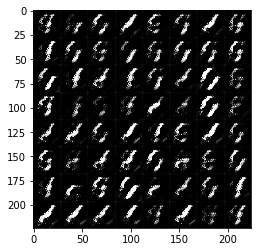

Epoch 1/2... Discriminator Loss: 0.2896... Generator Loss: 2.3444
Epoch 1/2... Discriminator Loss: 0.1290... Generator Loss: 8.5682
Epoch 1/2... Discriminator Loss: 0.1971... Generator Loss: 3.1005
Epoch 1/2... Discriminator Loss: 0.1561... Generator Loss: 3.5505
Epoch 1/2... Discriminator Loss: 0.3874... Generator Loss: 3.6047
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 1.5252
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 3.4949
Epoch 1/2... Discriminator Loss: 0.3121... Generator Loss: 2.2571
Epoch 1/2... Discriminator Loss: 0.2856... Generator Loss: 2.1730
Epoch 1/2... Discriminator Loss: 0.2966... Generator Loss: 4.0353


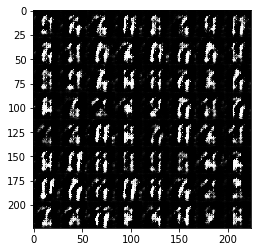

Epoch 1/2... Discriminator Loss: 0.6438... Generator Loss: 2.6192
Epoch 1/2... Discriminator Loss: 0.3026... Generator Loss: 3.2182
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 4.0894
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 1.8544
Epoch 1/2... Discriminator Loss: 0.4985... Generator Loss: 1.2437
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 1.8821
Epoch 1/2... Discriminator Loss: 0.3086... Generator Loss: 2.8157
Epoch 1/2... Discriminator Loss: 0.3064... Generator Loss: 2.4081
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.0857


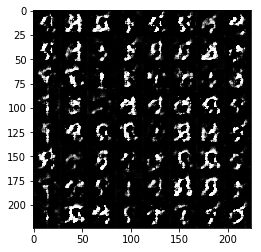

Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 0.4262... Generator Loss: 1.9918
Epoch 1/2... Discriminator Loss: 0.4732... Generator Loss: 2.6809
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.3373
Epoch 1/2... Discriminator Loss: 0.5884... Generator Loss: 3.5709
Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 1.5499


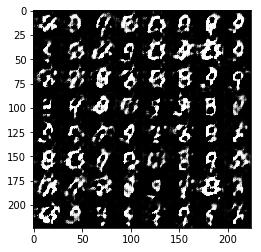

Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 2.1222
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 1.9883
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 3.0424
Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 1.8919
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 1.3764
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 1.4981
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 1.5156


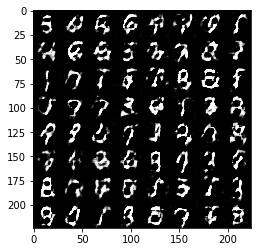

Epoch 1/2... Discriminator Loss: 0.8653... Generator Loss: 1.5418
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.6066
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 1.7594
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.2936
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 3.3170
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.8410


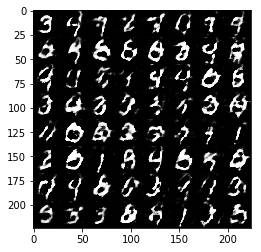

Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.4773
Epoch 1/2... Discriminator Loss: 0.4023... Generator Loss: 1.9544
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.1369
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 2.2751
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 3.0002
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 2.3648
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.4143
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.2143
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.8431... Generator Loss: 0.3722


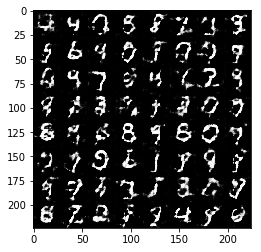

Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 3.6320
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 1.5321
Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 2.1357
Epoch 1/2... Discriminator Loss: 0.7860... Generator Loss: 1.6972
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 2.3152... Generator Loss: 0.1575
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.5691
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 1.0009


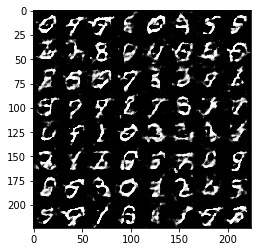

Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.7139
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.3591
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 1.3639
Epoch 1/2... Discriminator Loss: 0.5901... Generator Loss: 1.6944
Epoch 1/2... Discriminator Loss: 0.4695... Generator Loss: 1.5054
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.7821
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 1.3909
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.5281


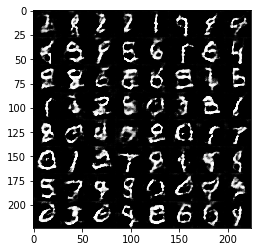

Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 0.7358
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 1.7068... Generator Loss: 0.3405
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.4475
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.1603
Epoch 1/2... Discriminator Loss: 0.8602... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 0.7063... Generator Loss: 2.7957
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 0.9741


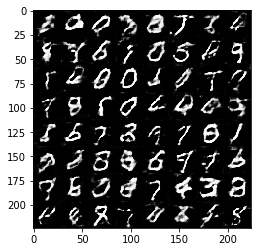

Epoch 1/2... Discriminator Loss: 0.7490... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 0.9476... Generator Loss: 1.0062
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 0.8114... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.9053... Generator Loss: 0.2815
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.3553
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.0905
Epoch 1/2... Discriminator Loss: 0.6915... Generator Loss: 1.2862
Epoch 1/2... Discriminator Loss: 0.7454... Generator Loss: 1.5702


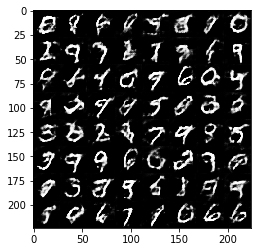

Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.3271
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.1658
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 1.1101
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.3085
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 1.2941
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.0390


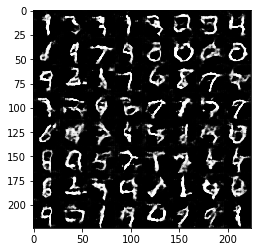

Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.1109
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.5416
Epoch 1/2... Discriminator Loss: 0.8274... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.5188


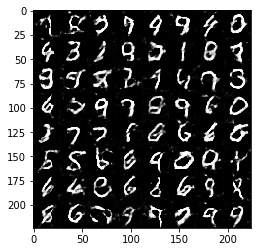

Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.4734


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 1.4075
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 2.0041
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 2.5169
Epoch 1/1... Discriminator Loss: 0.3121... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 0.1268... Generator Loss: 2.7851
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 0.3250... Generator Loss: 1.8969
Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 3.1103


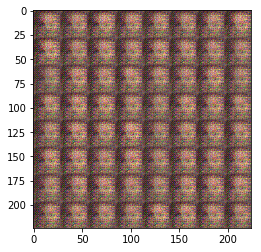

Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 8.0504
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 5.0992
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.2174... Generator Loss: 2.3371
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 1.5877
Epoch 1/1... Discriminator Loss: 0.2022... Generator Loss: 3.7436
Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 4.0449
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 3.2775
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 2.7316
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 4.1927


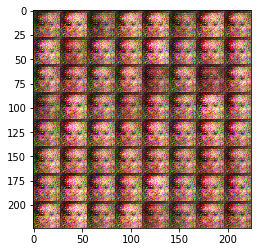

Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 3.4178
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 2.1688
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 2.1462
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 5.7577
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 1.8658
Epoch 1/1... Discriminator Loss: 0.2891... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 2.6482
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 1.9498
Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 1.3421


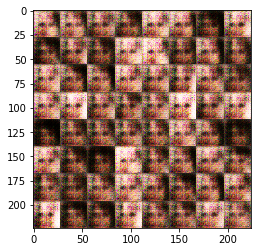

Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 2.1807
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.6810
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 2.1125
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.0286


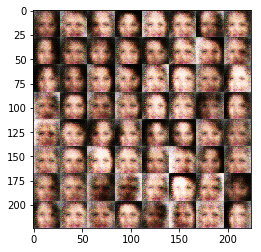

Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 2.2759
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.7787
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 2.4475
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.4311


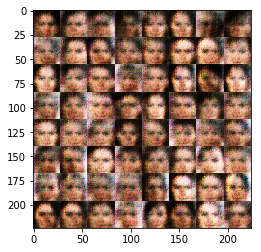

Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.4545


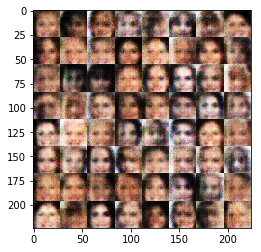

Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.5399
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 2.5090
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 2.6777
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.4764


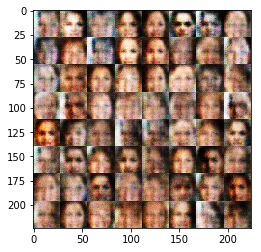

Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 2.5982
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 2.2254
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.1365


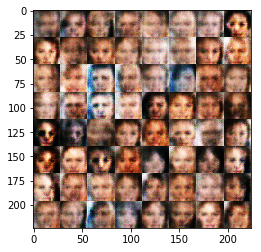

Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.7002
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 0.9965


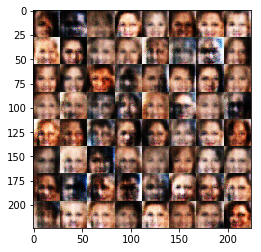

Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.5182


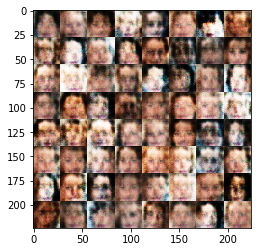

Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.4843
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.6160
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.7187


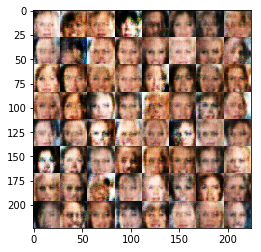

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.7997
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.1652


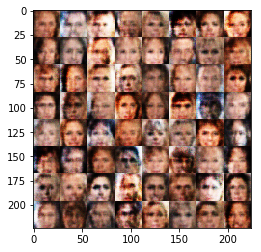

Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 2.6324
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.1736


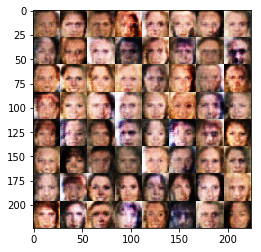

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.7753
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8915


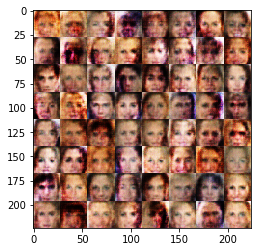

Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.9522


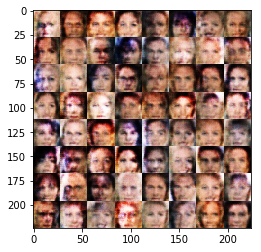

Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.4584
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 2.0585
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 1.5456


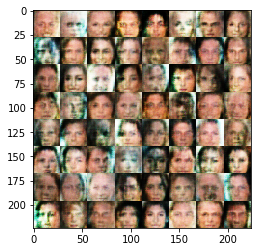

Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.1535


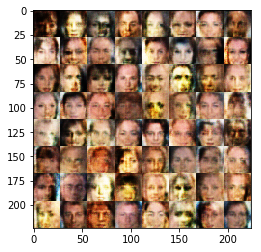

Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.1790
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.7172


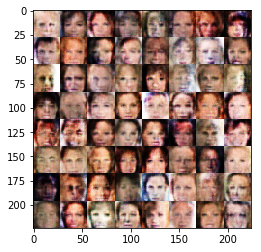

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.5960


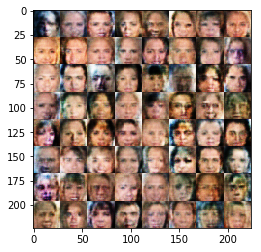

Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.0239


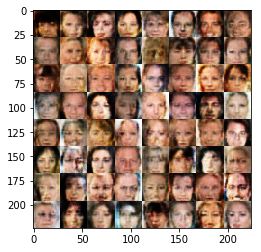

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.5506
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.8358


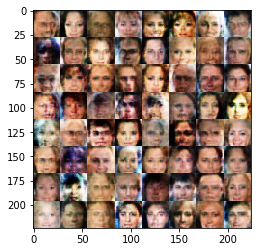

Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.8551


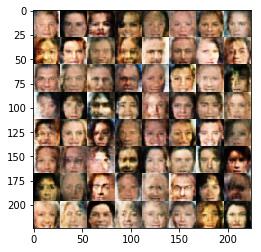

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.9354


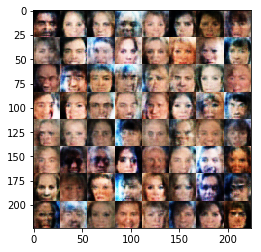

Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.0364


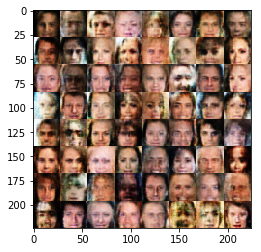

Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.8719
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.7279
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5252


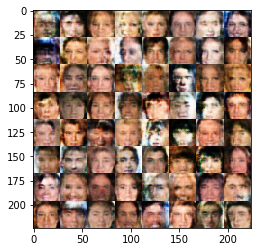

Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.4570
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8624


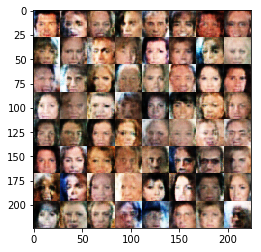

Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.6127


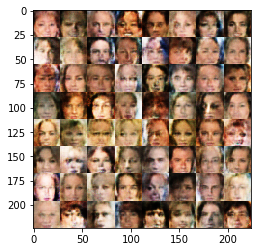

Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.9574


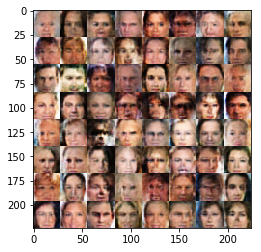

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.8709


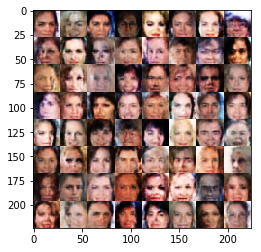

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.4441


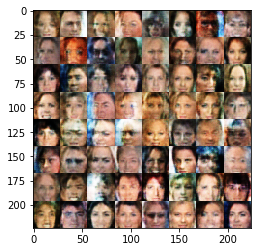

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7557


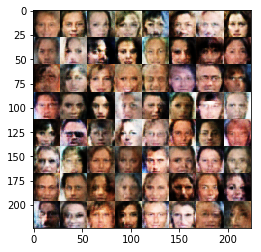

Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.3797


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.